<a href="https://colab.research.google.com/github/mpurvesh007/Data-Ingestion-Pipeline---Week-6/blob/main/cab_data_ingestion_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Installing Required Library

In [18]:
!pip install dask
!pip install modin[all]
!pip install ray


(raylet) [2023-12-07 13:36:58,272 E 767 767] (raylet) node_manager.cc:3035: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: eb3990f07c7bc89fbb7437c5714c0f8f554c6f3859145815b644d70a, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [5]:
import pandas as pd
import dask.dataframe as dd
import modin.pandas as mpd
import ray
ray.init()
import os


# 2. Mounting Google drive to read the file stored in drive directly

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Defining the file path from google drive
file_path = '/content/drive/MyDrive/yellow_tripdata_2015-03.csv'

# 3. Different methods of file reading Dask, Modin, Ray, pandas and presenting  the findings in terms of reading time

In [8]:
# Print time taken by Pandas to read the file
%time df_pandas = pd.read_csv(file_path)

CPU times: user 48.7 s, sys: 12.9 s, total: 1min 1s
Wall time: 1min 16s


In [9]:
# print first 5 rows of dataframe
df_pandas.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-03-06 08:02:31,2015-03-06 08:09:55,1,1.2,-73.990211,40.750969,1,N,-73.987892,40.738037,2,7.0,0.0,0.5,0.00,0.0,0.3,7.80
1,1,2015-03-06 08:02:31,2015-03-06 08:15:23,1,3.2,-73.935188,40.800720,1,N,-73.952553,40.765373,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30
2,1,2015-03-06 08:02:31,2015-03-06 08:12:27,1,1.1,-73.963753,40.767937,1,N,-73.956947,40.780270,2,8.0,0.0,0.5,0.00,0.0,0.3,8.80
3,1,2015-03-06 08:02:31,2015-03-06 08:09:09,1,0.8,-73.997177,40.742168,1,N,-74.008064,40.739281,1,6.0,0.0,0.5,1.00,0.0,0.3,7.80
4,1,2015-03-06 08:02:32,2015-03-06 08:19:37,1,2.7,-74.006844,40.730267,1,N,-73.976860,40.750671,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [10]:
# performing reading of file using dask
import dask.dataframe as dd

# Measure time taken by Dask to read the file
%time df_dask = dd.read_csv(file_path)

CPU times: user 16.2 ms, sys: 170 ms, total: 186 ms
Wall time: 211 ms


In [11]:
import dask.dataframe as dd

# Specify dtype for 'extra' and 'tolls_amount'
dtype_spec = {'extra': 'float64', 'tolls_amount': 'float64'}

# Read CSV with explicit dtype specification
df_dask = dd.read_csv(file_path, assume_missing=True, dtype=dtype_spec)

# Displaying the first few 5 row
df_dask.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1.0,2015-03-06 08:02:31,2015-03-06 08:09:55,1.0,1.2,-73.990211,40.750969,1.0,N,-73.987892,40.738037,2.0,7.0,0.0,0.5,0.00,0.0,0.3,7.80
1,1.0,2015-03-06 08:02:31,2015-03-06 08:15:23,1.0,3.2,-73.935188,40.800720,1.0,N,-73.952553,40.765373,2.0,11.5,0.0,0.5,0.00,0.0,0.3,12.30
2,1.0,2015-03-06 08:02:31,2015-03-06 08:12:27,1.0,1.1,-73.963753,40.767937,1.0,N,-73.956947,40.780270,2.0,8.0,0.0,0.5,0.00,0.0,0.3,8.80
3,1.0,2015-03-06 08:02:31,2015-03-06 08:09:09,1.0,0.8,-73.997177,40.742168,1.0,N,-74.008064,40.739281,1.0,6.0,0.0,0.5,1.00,0.0,0.3,7.80
4,1.0,2015-03-06 08:02:32,2015-03-06 08:19:37,1.0,2.7,-74.006844,40.730267,1.0,N,-73.976860,40.750671,1.0,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [16]:
import modin.pandas as mpd

# Find time taken by Modin to read the file
%time df_modin = mpd.read_csv(file_path)

2023-12-07 13:34:38,690	WARNING worker.py:2074 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 2e9401c63795d7c9f15be3cab49200215bd4373c01000000 Worker ID: 5c2a53f4319e94d5b020d8ee4bdb4d5acc284fa65a861b589c39e443 Node ID: eb3990f07c7bc89fbb7437c5714c0f8f554c6f3859145815b644d70a Worker IP address: 172.28.0.12 Worker port: 39721 Worker PID: 822 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
(raylet) [2023-12-07 13:34:58,269 E 767 767] (raylet) node_manager.cc:3035: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID:

KeyboardInterrupt: ignored

In [7]:
import ray.dataframe as rd

ray.init()

# Record the time taken by Ray
%time df_ray = rd.read_csv(file_path)

ray.shutdown()


ModuleNotFoundError: ignored

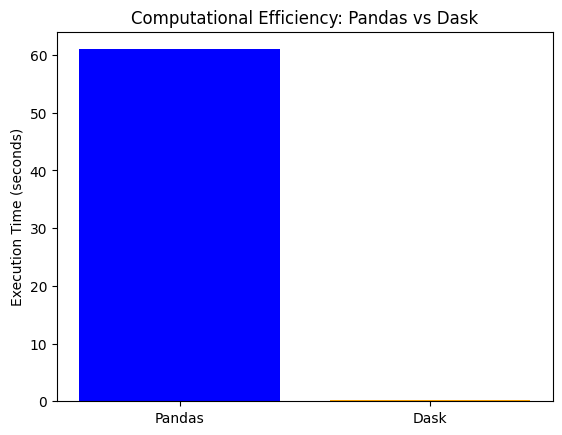

In [18]:
import matplotlib.pyplot as plt

# Execution times
pandas_time = 1 * 60 + 1  # 1 minute and  1 seconds
dask_time = 0.186  # 186 milliseconds

# Create a bar plot
labels = ['Pandas', 'Dask']
times = [pandas_time, dask_time]

plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Execution Time (seconds)')
plt.title('Computational Efficiency: Pandas vs Dask')
plt.show()


In [12]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13351609 entries, 0 to 13351608
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.9+ GB


# 4. create a YAML file and write the column name in YAML file while defining separator of read and write file, column name in YAML



In [13]:
yaml_config = """
file_type: csv
dataset_name: mydataset
file_name: file_path
table_name: mytable
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns:
    - VendorID
    - tpep_pickup_datetime
    - tpep_dropoff_datetime
    - passenger_count
    - trip_distance
    - pickup_longitude
    - pickup_latitude
    - RateCodeID
    - store_and_fwd_flag
    - dropoff_longitude
    - dropoff_latitude
    - payment_type
    - fare_amount
    - extra
    - mta_tax
    - tip_amount
    - tolls_amount
    - improvement_surcharge
    - total_amount
"""


# Define the directory path
directory_path = '/content/drive/MyDrive/path/to/'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save YAML configuration to a file
yaml_file_path = os.path.join(directory_path, 'config.yaml')
with open(yaml_file_path, 'w') as file:
    file.write(yaml_config)

# Print the path where the YAML file is saved for further analysis
print(f"YAML file saved to: {yaml_file_path}")


YAML file saved to: /content/drive/MyDrive/path/to/config.yaml


In [14]:
from testutility import read_config_file


ModuleNotFoundError: ignored

# 5.Validate number of columns and column name of ingested file with YAML.

In [16]:
# Import necessary libraries
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime
import gc
import re

# Function to read a YAML configuration file
def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

# Function to replace consecutive occurrences of a character in a string
def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

# Function to validate column names in a DataFrame against expected configuration
def col_header_val(df, table_config):
    '''
    Replace whitespaces in the column
    and standardize column names
    '''
# Convert column names to lowercase and replace non-word characters with underscores
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]', '_', regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x, '_'), list(df.columns)))

# Extract and sort expected column names from the configuration
    expected_col = list(map(lambda x: x.lower(), table_config['columns']))
    expected_col.sort()

# Standardize DataFrame column names
    df.columns = list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    # Validate column names and lengths
    if len(df.columns) == len(expected_col) and list(expected_col) == list(df.columns):
        print("Column name and column length validation passed")
        return 1
    else:
        print("Column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file", mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded", missing_YAML_file)
        return 0

# Load YAML configuration
yaml_file_path = '/content/drive/MyDrive/path/to/config.yaml'
with open(yaml_file_path, 'r') as stream:
    try:
        table_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        logging.error(exc)

# Validate columns
col_header_val_result = col_header_val(df_pandas, table_config)

Column name and column length validation passed


# 6. Write the file in pipe separated text file (|) in gz format.
# 7. Create a summary of the file:

## Total number of rows,

## Total number of columns

## File size



In [17]:
# Write the file in pipe-separated text file (|) in gz format
output_file_path = os.path.join(directory_path, 'output_file.gz')
df_pandas.to_csv(output_file_path, sep='|', compression='gzip', index=False)

# Create a summary of the file
total_rows = df_pandas.shape[0]
total_columns = df_pandas.shape[1]
file_size = os.path.getsize(output_file_path) / (1024 * 1024)  # Convert to MB

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")
print(f"File size: {file_size:.2f} MB")


Total number of rows: 13351609
Total number of columns: 19
File size: 516.63 MB
